# Twitter Thesis Project: Analyzing tweets 

## Label your tweets (this is a manual step!)


In order to teach the computer how to classify the tweets automatically, we have to feed the program a lot of tweets together with the class they belong to. These example tweets have to be 'labeled' (given a label that indicates which class they belong to) by someone who can tell the correct class simply from reading the tweet (you). 

These are the steps you can take to prepare your tweet dataset for classification:

- decide on the classes you want to use. 
- number these classes from 0 to the number of classes you have - 1. E.g., if you have 4 classes, you need to use the labels 0,1,2,3. 
- add a column to your dataset (or safer: create a copy of your dataset and add a new column there) where you add the correct label for each of your tweets. To start, try to label at least 100 tweets for each class. It will become clear later on if the classifier needs more examples to learn from. 

**Example: tweets with the keyword 'brussel'**

As an example application, we have collected (through streaming) a number of tweets which contain the keyword 'brussel'. Since the keyword is Dutch, most of the collected tweets are also in Dutch. We would like to train a classifier that automically determines whether a new tweet belongs to one of the following classes: mobility (0), politics or opinion on politics (1), brussels sprouts (2), other (3). We have changed the original file of collected tweets by adding a column with the correct labels. Examples of each class include:

*De trein tussen Brussel en Mechelen, eender welke, da's toch echt roulette spelen: welke komt met het minste vertra… https://t.co/wJ4uXA906d* **(label: 0)**

*@peeters_kris1 @Europarl_NL Mijnheer Peeters, hieronder het nefaste resultaat van de Europese immigratiepolitiek. D… https://t.co/Ia92qNOMcQ* **(label: 1)**

*@GavinWren Tamales
Brussel Sprouts
Lemons* **(label: 2)**

*#Reminder | Over slechts twee dagen vindt de vierde editie van de Mansholtlezing in Brussel plaats over de eiwittra… https://t.co/XJTRGfZhZ* **(label: 3)**





## Load all the additional libraries and tools we will use

In [72]:
import pandas as pd #this is a datascience library that we will use to load and preprocess the tweets
import matplotlib.pyplot as plt #this is a plotting library that we will use to make graphs
from sklearn.feature_extraction.text import TfidfVectorizer #this is a machine learning tool we will use to find a mathematical representation of the tweets
from sklearn.feature_selection import chi2

from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import numpy as np

## Load the tweets you previously collected and annotated

### Load the annotated tweets

In [62]:
tweet_dataset = pd.read_csv('annotated_tweets_keyword_brussel.csv', delimiter = ';', skiprows = 1) #you can change the name of the file you want to load here

tweet_dataset = tweet_dataset[0:917]
tweet_dataset.Label = tweet_dataset.Label.astype(int) #to make sure the labels are correclty read as integer values
tweet_dataset.head() #this will show the top lines in your dataset


,Date,Place,Text,Label
0,Mon Sep 16 08:19:26 +0000 2019,NaN,@jdceulaer @DenysJan @barthaeck @BenWeyts @tij...,1
1,Mon Sep 16 08:19:28 +0000 2019,NaN,"Van afgelopen april. Maar vanwege het filmpje,...",3
2,Mon Sep 16 08:21:17 +0000 2019,NaN,just got my ticket for blackbear in Brussel 🥺 ...,3
3,Mon Sep 16 08:21:40 +0000 2019,NaN,@IFiselier Brussel bewolkt en fris,3
4,Mon Sep 16 08:22:22 +0000 2019,NaN,JA ONS BELASTING GELD HAHAHAHAHA WAT EEN WEREL...,1


### Make a graph of how many tweets per category you have

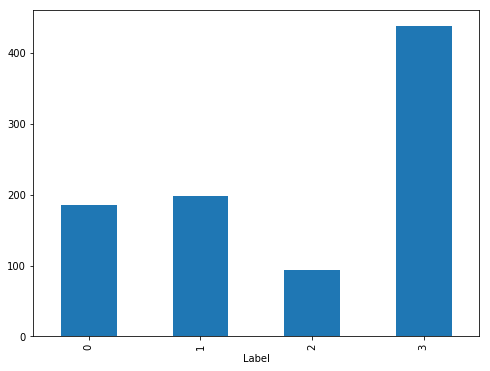

In [63]:
fig = plt.figure(figsize=(8,6))
tweet_dataset.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

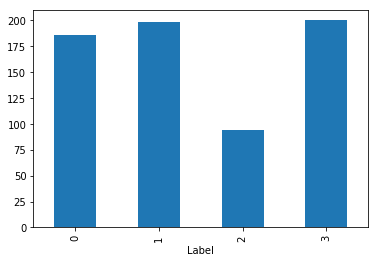

In [76]:
# Separate majority and minority classes
df = tweet_dataset; 
df_majority = df[df.Label==3]
df_minority = pd.concat([df[df.Label==0],df[df.Label==1],df[df.Label==2]])
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=200,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 

tweet_dataset = df_downsampled;
tweet_dataset.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()




## Convert the tweet texts to an input format the classifier can read

The classifier, i.e., a computer program, will perform certain mathematical operations on each tweet to determine which class it belongs to. We thus have to feed the classifier with a mathematical representation of the tweet. We will used a method called 'bag of words' to find mathemical representations (in the form of **vectors**) for each tweet text. 

### Convert the tweets to vectors

In [77]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(tweet_dataset.Text).toarray()
labels = tweet_dataset.Label
features.shape

(678, 356)

### (Intermezzo: Check the important words per class)

In [78]:

class_to_labels = {
    'mobility' : 0, 
    'politics' : 1, 
    'sprouts' : 2, 
    'other' : 3
}

#category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
#category_to_id = dict(category_id_df.values)
#id_to_category = dict(category_id_df[['category_id', 'Product']].values)
#df.head()


N = 5
for category, label in sorted(class_to_labels.items()):
  features_chi2 = chi2(features, labels == label)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(category))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'mobility':
  . Most correlated unigrams:
. trein
. minuten
. vertraagd
. beneluxtrein
. zuid
  . Most correlated bigrams:
. brussel sprouts
. zuid minuten
. naar brussel
. minuten vertraagd
. brussel zuid
# 'other':
  . Most correlated unigrams:
. valtònyc
. espanya
. sprouts
. que
. les
  . Most correlated bigrams:
. que espanya
. brussel https
. valtònyc https
. brussel sprouts
. brussel les
# 'politics':
  . Most correlated unigrams:
. heeft
. de_nva
. thierrybaudet
. sprouts
. eu
  . Most correlated bigrams:
. brussel les
. brussel en
. uit brussel
. aan brussel
. brussel sprouts
# 'sprouts':
  . Most correlated unigrams:
. like
. dinner
. eat
. sprout
. sprouts
  . Most correlated bigrams:
. brussel en
. brussel les
. sprouts https
. brussel sprout
. brussel sprouts


## Train a classifier on the tweets represented as vectors 

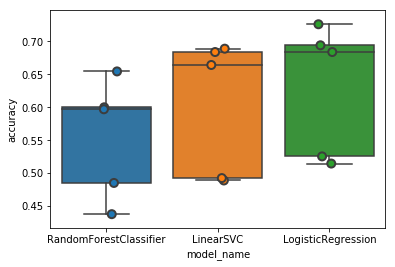

In [79]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

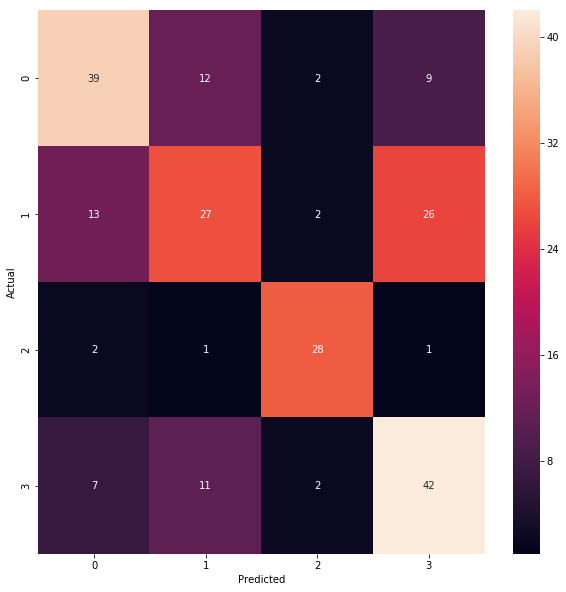

In [80]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, tweet_dataset.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()